# Lo repetido

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano.tensor as tt
import pymc3 as pm

#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from IPython.core.pylabtools import figsize

#sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


In [3]:
wake1 = pd.read_csv("wake1_data.csv")
wake2 = pd.read_csv("wake2_data.csv")

In [4]:
n_samples = 5000

wake1_obs = wake1["Sleep"].values
wake1_time = wake1["Offset"].values

wake2_obs = wake2["Sleep"].values
wake2_time = wake2["Offset"].values

In [5]:
def metropolis_hasting(obs, time, samples, start=None):
    with pm.Model() as model:
        # Parámetros beta0 y beta1
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)

        # Probabilidad de la función logistica
        p = pm.Deterministic('p',  1 / (1 + np.exp(-(beta0 + beta1*time)))) 

        # Parametro bernoulli que usa los datos observados
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando Metropolis
        step = pm.Metropolis()
        #db = pm.backends.Text('met')
        # Samplear de la posterior usando Metropolis
        trace = pm.sample(samples, step=step, njobs=1, start=start)#, trace=db);
        #gelman = pm.gelman_rubin(trace)
    return model, trace

def slice_sampling(obs, time, samples):
    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)
        p = pm.Deterministic('p', 1. / (1. + tt.exp(-(beta0 + beta1 * time))))
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando Slice sampling
        step = pm.Slice()

        # Samplear de la posterior usando Slice sampling
        trace = pm.sample(samples, step=step, njobs=1);
    return model, trace

def hamiltonian_mc(obs, time, samples):
    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0.0, sd=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, sd=0.01, testval=0.0)
        p = pm.Deterministic('p', 1. / (1. + tt.exp(-(beta0 + beta1 * time)))+1e-10)
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando Hamiltonian Monte Carlo
        step = pm.HamiltonianMC()

        # Samplear de la posterior usando Hamiltonian Monte Carlo
        trace = pm.sample(samples, step=step, njobs=1);
    return model, trace

def nuts(obs, time, samples):
    with pm.Model() as model:
        beta0 = pm.Normal('beta0', mu=0.0, sd=0.01, testval=0.0)
        beta1 = pm.Normal('beta1', mu=0.0, sd=0.01, testval=0.0)
        p = pm.Deterministic('p', 1. / (1. + tt.exp(-(beta0 + beta1 * time))))
        observed = pm.Bernoulli('obs', p, observed=obs)

        # Usando NUTS
        step = pm.NUTS()
        # Samplear de la posterior usando NUTS
        trace = pm.sample(samples, step=step, njobs=1);
    return model, trace

In [6]:
# Labels para plots
sleep_labels = ['8:00','8:30','9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['4:00','4:30','5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

def plot_hist(beta0, beta1, samples, suptitle):
    figsize(16, 5)

    plt.subplot(121)
    plt.title(r"""Distribucion de $\beta_0$ con %d muestras""" % samples)
    plt.hist(beta0, histtype='stepfilled', color = 'darkred', bins=30, density=True);
    plt.ylabel('Densidad de probabilidad')
    
    plt.subplot(122)
    plt.title(r"""Distribucion de $\beta_1$ con %d muestras""" % samples)
    plt.hist(beta1, histtype='stepfilled', color = 'darkblue', bins=30, density=True)
    plt.ylabel('Densidad de probabilidad')
    plt.suptitle(suptitle)
    plt.show()
    
def plot_fit(time_est, sleep_est_1, sleep_est_2, sleep_est_3, sleep_est_4, time, obs, samples, title, m, labels):    
    figsize(16, 6)

    plt.plot(time_est, sleep_est_1, color = 'navy', lw=10, label="Modelo logistico MH")
    plt.plot(time_est, sleep_est_2, color = 'green', lw=10, label="Modelo logistico NUTS")
    plt.plot(time_est, sleep_est_3, color = 'red', lw=3, label="Modelo logistico HamiltonMC")
    plt.plot(time_est, sleep_est_4, color = 'yellow', lw=3, label="Modelo logistico Slice")
    plt.scatter(time, obs, edgecolor = 'slateblue', s=50, alpha=0.2, label='obs')
    plt.suptitle(title)
    plt.title('Distribución de probabilidad con %d muestras' % samples);
    plt.legend(prop={'size':18})
    plt.ylabel('Probabilidad')
    plt.xlabel('Hora ' + m);
    plt.xticks([-120,-90,-60, -30, 0, 30, 60, 90, 120], labels);
    
def plot_fit_colormap(trace, time, obs, labels, m):
    colors  =  ["#348ABD" , "#A60628", "#7A68A6"]
    cmap = clr.LinearSegmentedColormap.from_list("BMH", colors)
    figsize(14, 7)
    probs = trace['p']
    plt.scatter(time, probs.mean(axis=0), cmap = cmap, c = probs.mean(axis=0), s = 50, label="Modelo logistico");
    plt.scatter(time, obs, edgecolor = 'green', color = 'green', s=50, alpha=0.2, label='obs')
    plt.title('Probabilidad de dormir como función del tiempo')
    plt.legend(prop={'size':18})
    plt.ylabel('Probabilidad')
    plt.xlabel('Hora ' + m)
    plt.xticks([-120,-90,-60, -30, 0, 30, 60, 90, 120], labels);
    plt.show()

In [7]:
def graph_analysis(trace, title):
    pm.traceplot(trace, ['beta0', 'beta1'], figsize=(12,6));
    pm.autocorrplot(trace = trace, varnames = ['beta0', 'beta1'], figsize=(12,6)); #no se muestra, pero si se quieta no se ve el traceplot .-.
    pm.forestplot(trace, varnames=['beta0', 'beta1']);
    pm.autocorrplot(trace = trace, varnames = ['beta0', 'beta1'], figsize=(12,6));
    
def geweke(trace, first = 0.1, last = 0.5):
    score=pm.geweke(trace, first=first, last=last)
    
    figsize(16, 8)
    plt.suptitle('Geweke Plot Comparando el primer 10% con el ultimo 50%  de la diferenrencia en cada cadena en Z score')
    
    plt.subplot(221)
    plt.scatter(score[[*score][0]]['beta0'][:,0],score[[*score][0]]['beta0'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta0'].shape[0]/2+10)
    plt.title(r"""Primera cadena $\beta_0$""")
        
    plt.subplot(222)
    plt.scatter(score[[*score][0]]['beta1'][:,0],score[[*score][0]]['beta1'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta1'].shape[0]/2+10)
    plt.title(r"""Primera cadena $\beta_1$""")
        
    plt.subplot(223)
    plt.scatter(score[[*score][-1]]['beta0'][:,0],score[[*score][-1]]['beta0'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta0'].shape[0]/2+10)
    plt.title(r"""Segunda cadena $\beta_0$""")
        
    plt.subplot(224)
    plt.scatter(score[[*score][-1]]['beta1'][:,0],score[[*score][-1]]['beta1'][:,1], marker = 'o', s=100)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.ylim(-2.5,2.5)
    plt.xlim(0-10,.5*trace['beta1'].shape[0]/2+10)
    plt.title(r"""Segunda cadena $\beta_1$""")
    plt.show()
    
def gelman_rubin(trace):
    conv = pm.gelman_rubin(trace, ['beta0', 'beta1'])
    print("Convergencia de Gelman-Rubin")
    if(conv['beta0'] > 0.98 and conv['beta0'] <1.1):
        print("\t El parámetro beta0 ha convergido")
    print("\t \t beta0: ", conv['beta0'])
    if(conv['beta1'] > 0.98 and conv['beta1'] <1.1):
        print("\t El parámetro beta1 ha convergido")
    print("\t \t beta1: ", conv['beta1'])
    
def running_means(trace):
    chains = []
    for i in trace.chains:
        beta0 = trace.get_values('beta0', chains=i)
        beta1 = trace.get_values('beta1', chains=i)
        means_beta0 = []
        means_beta1 = []
        for i in range(1,len(trace)):
            means_beta0 = np.append(means_beta0, sum(beta0[:i])/i)
            means_beta1 = np.append(means_beta1, sum(beta1[:i])/i)
        chains.append([means_beta0, means_beta1])
    
    i=0
    for chain in chains:
        i+=1
        x_axis = range(len(trace)-1)
        plt.figure(figsize=(15, 5))
        plt.suptitle("Running means para la cadena numero " + str(i))
        plt.subplot(121)
        plt.plot(x_axis, chain[0])
        plt.xlabel("Iteraciones")
        plt.ylabel("beta0")

        plt.subplot(122)
        plt.plot(x_axis, chain[1])
        plt.xlabel("Iteraciones")
        plt.ylabel("beta1")
        plt.show()

In [8]:
reg_logistic = lambda x, beta0, beta1 : 1 / (1 + np.exp(-(beta0 + beta1*x)))

# Lo nuevo

In [11]:
wake1_met_model, wake1_met = metropolis_hasting(wake1_obs, wake1_time, n_samples)
wake2_met_model, wake2_met = metropolis_hasting(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:20<00:00, 274.56it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta1]
>Metropolis: [beta0]
100%|██████████| 5500/5500 [00:36<00:00, 150.38it/s]
The number of effective samples is smaller than 10% for some parameters.


In [12]:
wake1_ss_model, wake1_ss = slice_sampling(wake1_obs, wake1_time, n_samples)
wake2_ss_model, wake2_ss = slice_sampling(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [beta1]
>Slice: [beta0]
100%|██████████| 5500/5500 [01:05<00:00, 83.75it/s]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [beta1]
>Slice: [beta0]
100%|██████████| 5500/5500 [02:08<00:00, 42.69it/s]


In [9]:
#wake1_hmc_model, wake1_hmc = hamiltonian_mc(wake1_obs, wake1_time, n_samples)
wake2_hmc_model, wake2_hmc = hamiltonian_mc(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
HamiltonianMC: [beta1, beta0]
100%|██████████| 5500/5500 [00:45<00:00, 120.86it/s]
The acceptance probability does not match the target. It is 0.8923378262041355, but should be close to 0.8. Try to increase the number of tuning steps.


In [49]:
#wake1_nut_model, wake1_nut = nuts(wake1_obs, wake1_time, n_samples)
wake2_nut_model, wake2_nut = nuts(wake2_obs, wake2_time, n_samples)

Sequential sampling (2 chains in 1 job)
NUTS: [beta1, beta0]
100%|██████████| 5500/5500 [01:12<00:00, 75.36it/s]


## Modelo Despertar +/-1 hora

El mismo análisis el proceso de dormir se realiza en esta sección. Sin embargo, solo se irán explicando las conclusiones más generales de los resultados

### Histograma de los parámetros estimados $\beta_0$ y $\beta_1$


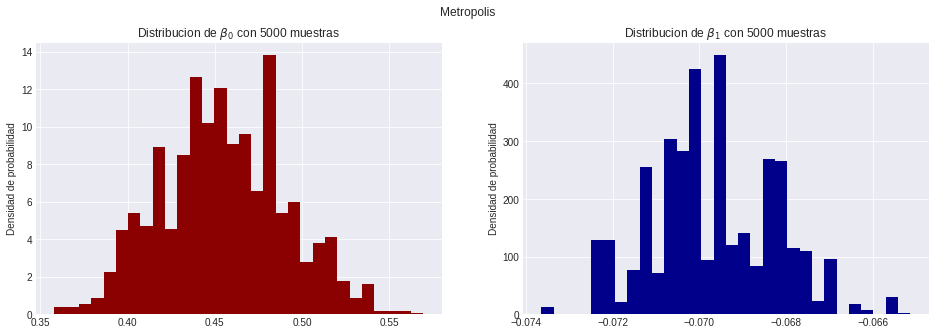

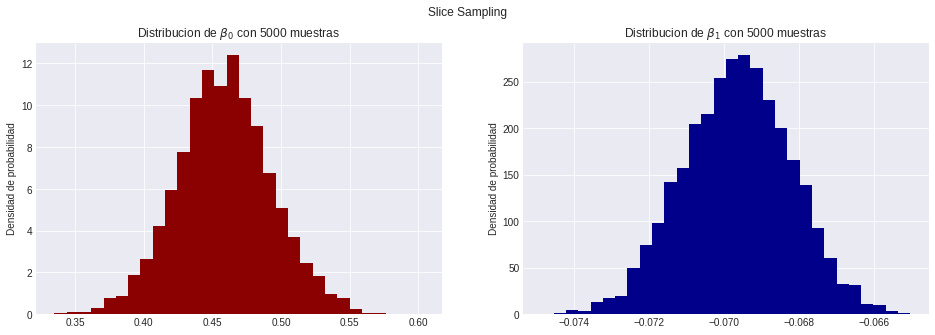

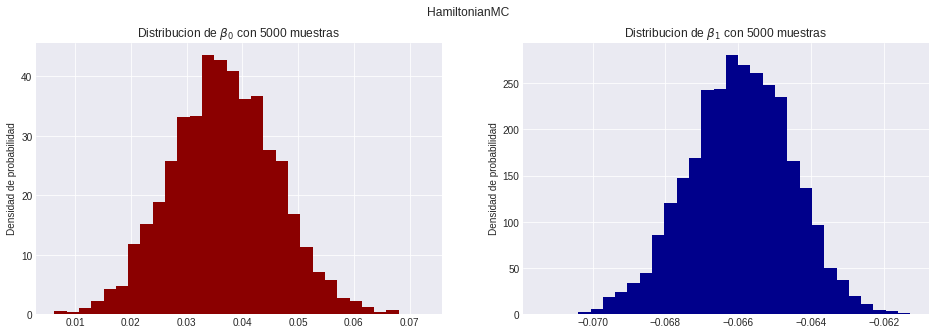

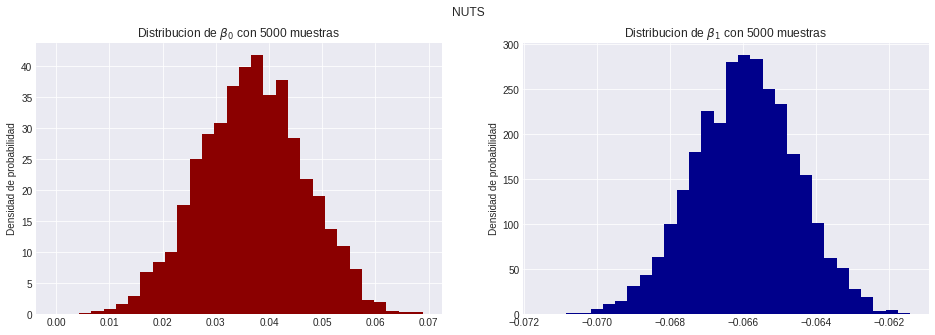

In [15]:
wake1_met_b = [wake1_met["beta0"][5000:], wake1_met["beta1"][5000:]]
wake1_ss_b = [wake1_ss["beta0"][5000:], wake1_ss["beta1"][5000:]]
wake1_hmc_b = [wake1_hmc["beta0"][5000:], wake1_hmc["beta1"][5000:]]
wake1_nut_b = [wake1_nut["beta0"][5000:], wake1_nut["beta1"][5000:]]

plot_hist(wake1_met_b[0], wake1_met_b[1], n_samples, "Metropolis")
plot_hist(wake1_ss_b[0], wake1_ss_b[1], n_samples, "Slice Sampling")
plot_hist(wake1_hmc_b[0], wake1_hmc_b[1], n_samples, "HamiltonianMC")
plot_hist(wake1_nut_b[0], wake1_nut_b[1], n_samples, "NUTS")

In [19]:
wake1_time_est = np.linspace(wake1_time.min()- 15, wake1_time.max() + 15)[:, None]

wake1_met_means = [wake1_met_b[0].mean(), wake1_met_b[1].mean()]
wake1_ss_means  = [wake1_ss_b[0].mean(),  wake1_ss_b[1].mean()]
wake1_hmc_means = [wake1_hmc_b[0].mean(), wake1_hmc_b[1].mean()]
wake1_nut_means = [wake1_nut_b[0].mean(), wake1_nut_b[1].mean()]

# Probabilidad en cada tiempo dado por las medias de las betas
wake1_met_est = reg_logistic(wake1_time_est, wake1_met_means[0], wake1_met_means[1])
wake1_ss_est  = reg_logistic(wake1_time_est, wake1_ss_means[0],  wake1_ss_means[1])
wake1_hmc_est = reg_logistic(wake1_time_est, wake1_hmc_means[0], wake1_hmc_means[1])
wake1_nut_est = reg_logistic(wake1_time_est, wake1_nut_means[0], wake1_nut_means[1])

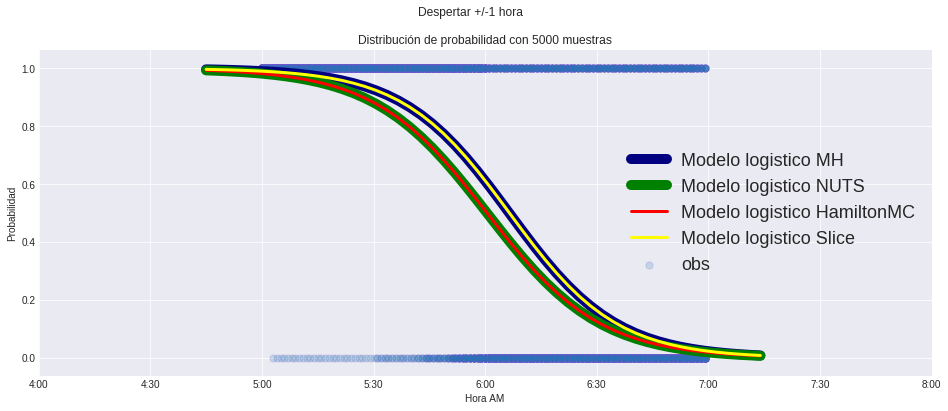

In [20]:
plot_fit(wake1_time_est, wake1_met_est, wake1_nut_est, wake1_hmc_est, wake1_ss_est,
         wake1_time, wake1_obs, n_samples, "Despertar +/-1 hora", "AM", wake_labels)

Las muestras obtenidas con Metropolis Hasting no se comportan de forma normal tan definidamente como los otros métodos, en especial para el parámetros $\beta_1$.

En los histogramas se aprecia como el parámetro $\beta_0$ es positivo, muy cercano al 0, y $\beta_1$ es negativo. Lo anterior se traduce en lo representado en el segundo gráfico, el cual está centrado alrededor de las 6:00 AM debido al parámetro $\beta_0$ y la pendiente es negativa debido al parámetro $\beta_1$. 

Además se puede seguir viendo el comportamiento de los distintos algoritmos de muestreo, en donde Metropolis-Hasting y Slice Sampling tienen un sampleo muy similar, al igual que Hamiltonian y NUTS.

### Análisis de convergencia

#### Análisis gráfico

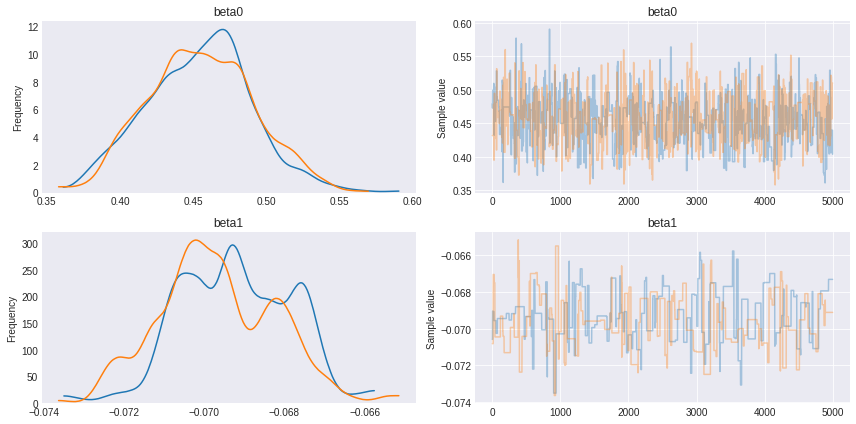

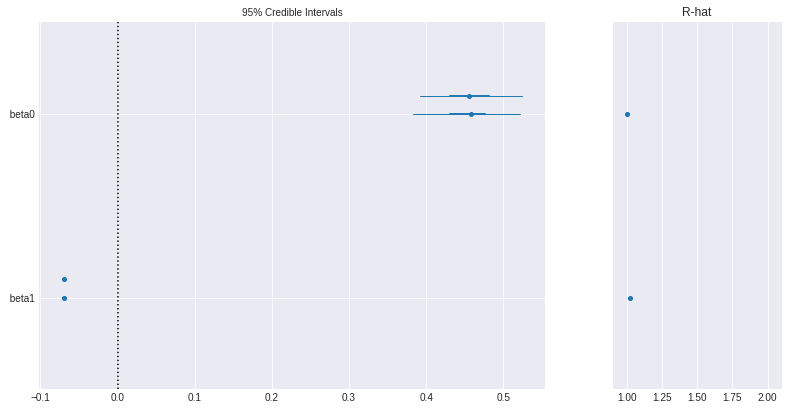

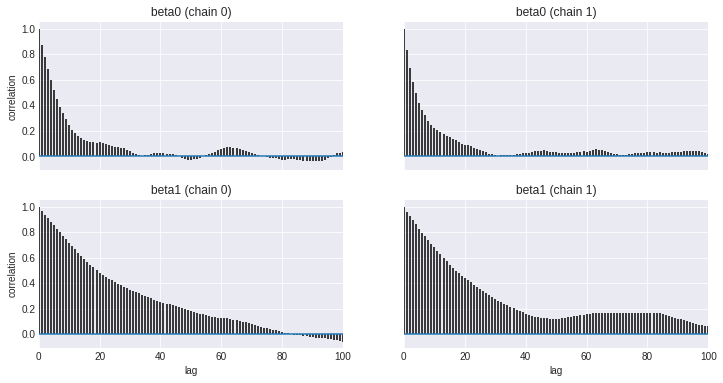

In [21]:
graph_analysis(wake1_met, "Despetar +/-1 hora Metropolis");

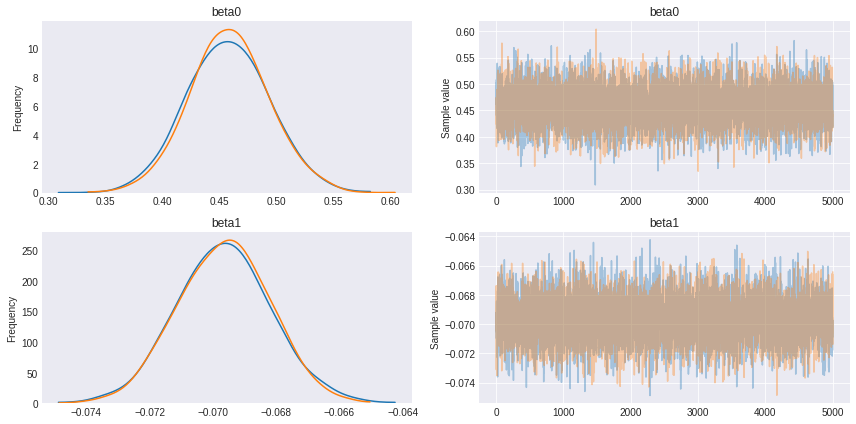

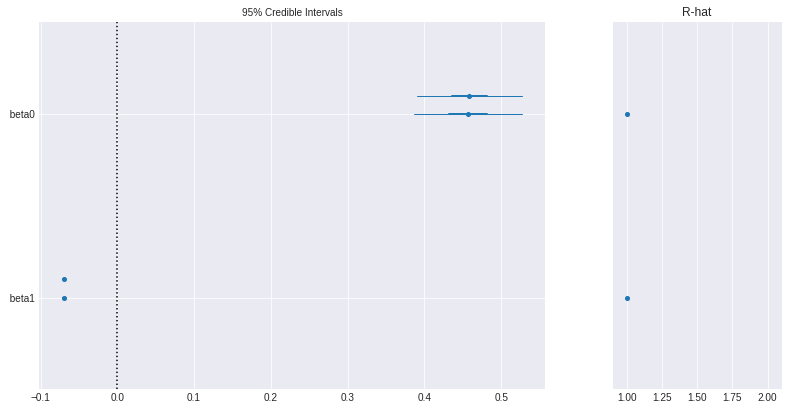

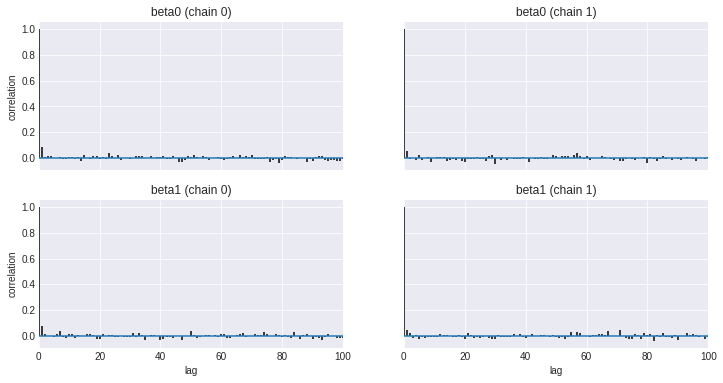

In [22]:
graph_analysis(wake1_ss, "Despetar +/-1 hora Slice Sampling");

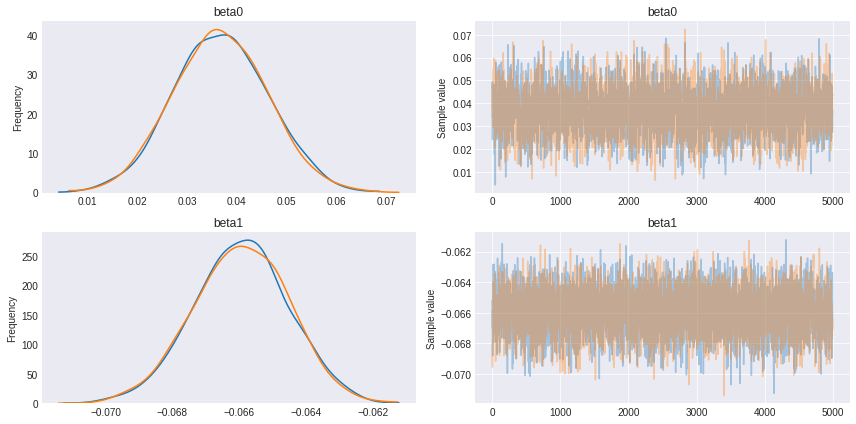

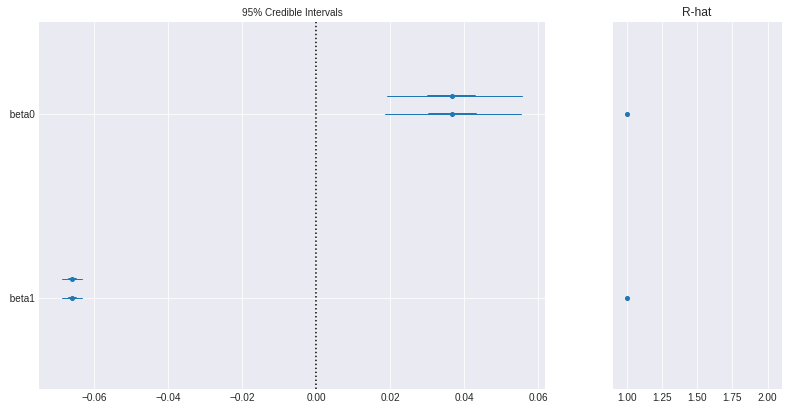

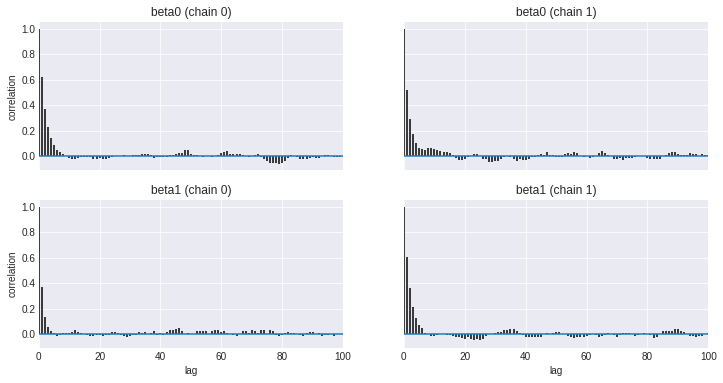

In [23]:
graph_analysis(wake1_hmc, "Despetar +/-1 hora HamiltonianMC");

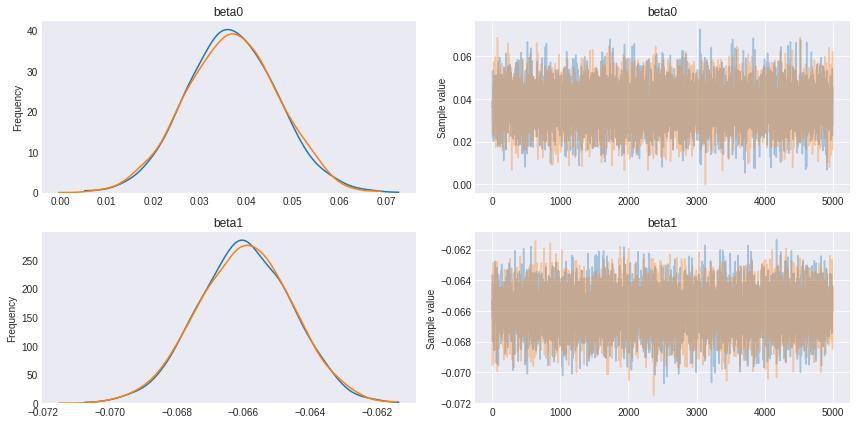

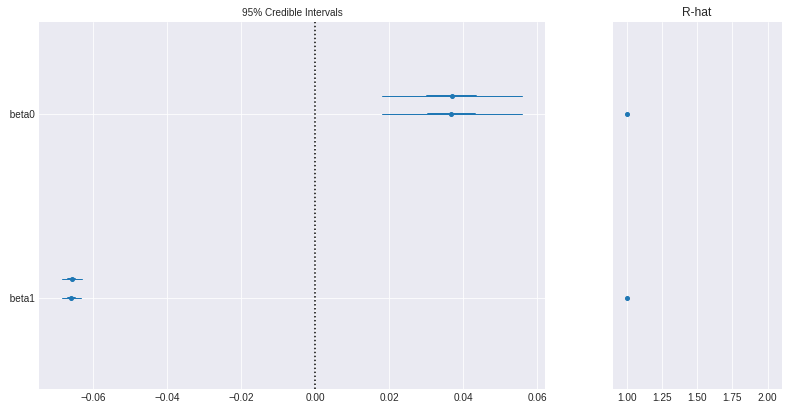

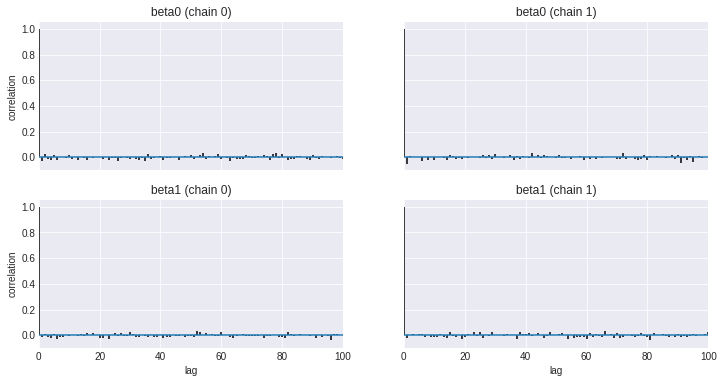

In [24]:
graph_analysis(wake1_nut, "Despetar +/-1 hora NUTS");

Mediante el análisis gráfico es posible vislumbrar la convergencia de todos los algoritmos de muestreo probados.

Metropolis-Hasting es el que peor resulta en la convergencia y muestreo. En el traceplot es posible ver como ambas cadenas muestreadas tienen un comportamiento bastante distinto entre sí, diferente a lo ocurrido con los otros algoritmos, los cuales se comportan bastante bien en este gráfico. De esta forma, apoya lo mostrado en los histogramas.

Por otro lado, el forest plot muestra como que segun el estadístico R-hat de Gelman-Rubin todos los métodos convergen. Y además muestra como las dos cadenas muestradas con cada método obtienen resultados muy parecidos.

Finalmente, el gráfico de autocorrelaciónes es el que muestra un peor comportamiento de Metropolis-Hasting, en donde se ve como la segunda cadena del parámetro $\beta_1$ aún no genera una distribución independiente según el análisis de este gráfico.

#### Geweke

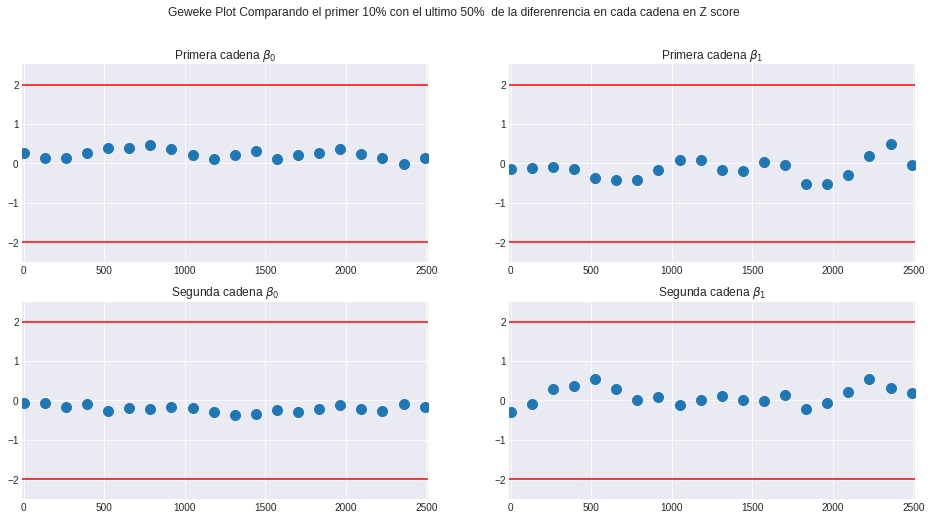

In [25]:
geweke(wake1_met)

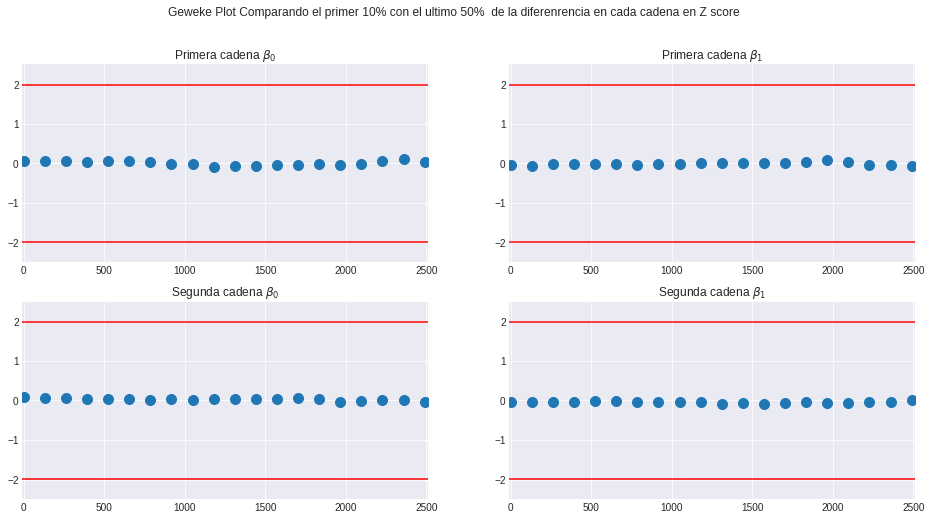

In [26]:
geweke(wake1_ss)

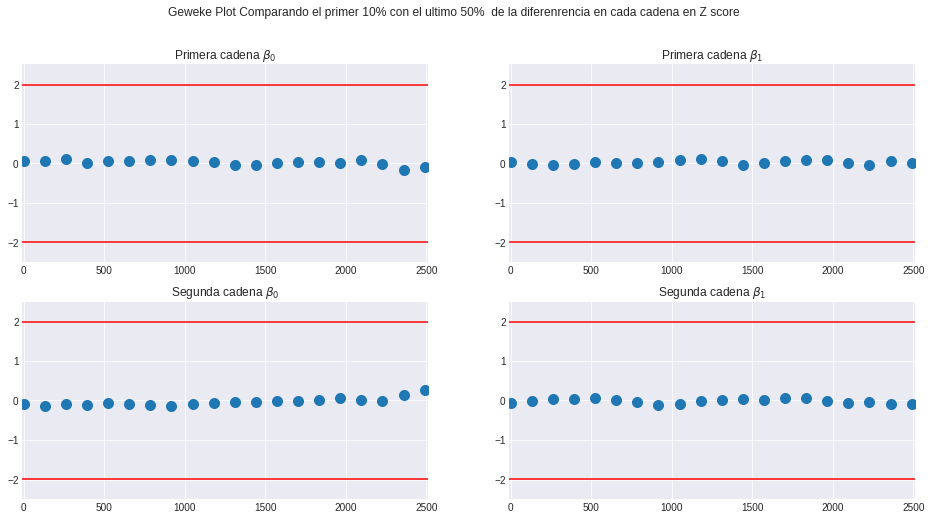

In [27]:
geweke(wake1_hmc)

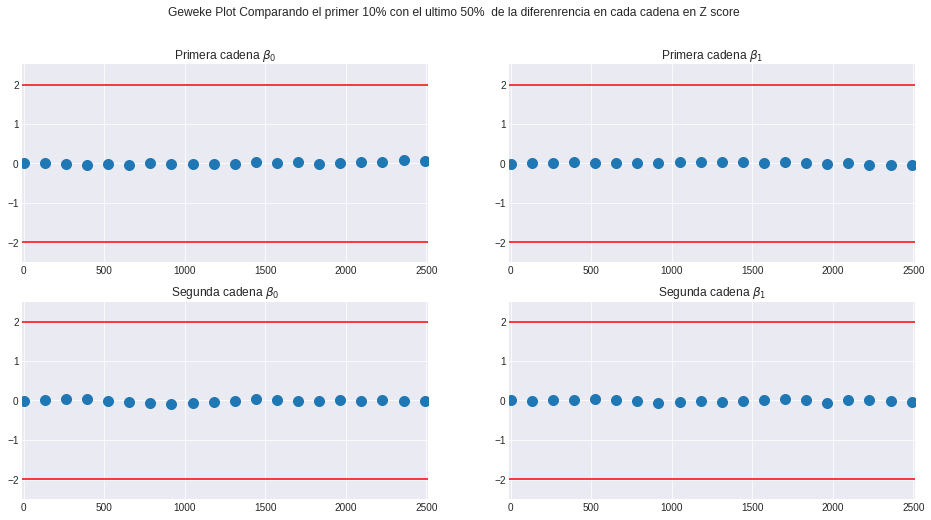

In [28]:
geweke(wake1_nut)

El método de convergencia Geweke viene a reforzar lo encontrados con los métodos gráficos. Se ve como Metropolis-Hasting tiene un coportamiento peor que el resto de los algoritmos, en especial en la segunda cadena de $\beta_1$. Sin embargo, ésto no quiere decir que tenga un mal comportamiento como quizás se pudo haber intuido del gráfico de autocorrelación.

Analizando ambas cadenas generadas por cada algoritmo y su resultado de Geweke, NUTS es el que se mejor se comporta, más estable dentro de la traza generada.

#### Gelman-Rubin

In [29]:
gelman_rubin(wake1_met)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  1.0000814339486241
	 El parámetro beta1 ha convergido
	 	 beta1:  1.0250937735540797


In [31]:
gelman_rubin(wake1_ss)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  1.0003245892812518
	 El parámetro beta1 ha convergido
	 	 beta1:  0.9999061598043429


In [32]:
gelman_rubin(wake1_hmc)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.9999229024184503
	 El parámetro beta1 ha convergido
	 	 beta1:  0.9999048931913216


In [33]:
gelman_rubin(wake1_nut)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.9999011426020133
	 El parámetro beta1 ha convergido
	 	 beta1:  0.9999069123382078


Estos resultados vienen a confirmar y reafirmar lo mostrados por los forest plot en los métodos gráficos, endonde según la prueba de convergencia Gelman-Rubin todos los algoritmos convergen para ambos parámetros.

#### Running Means

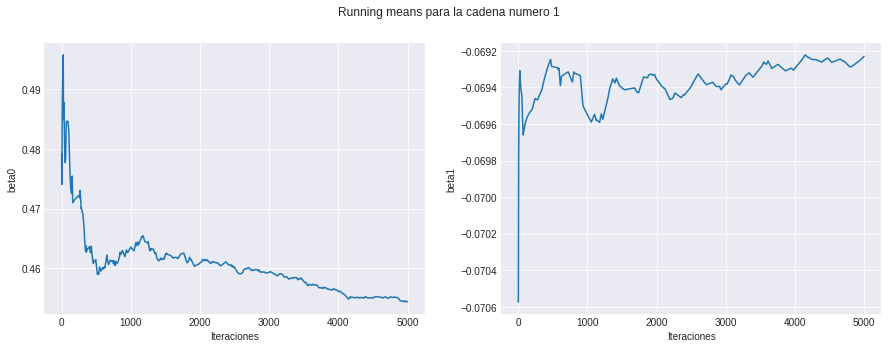

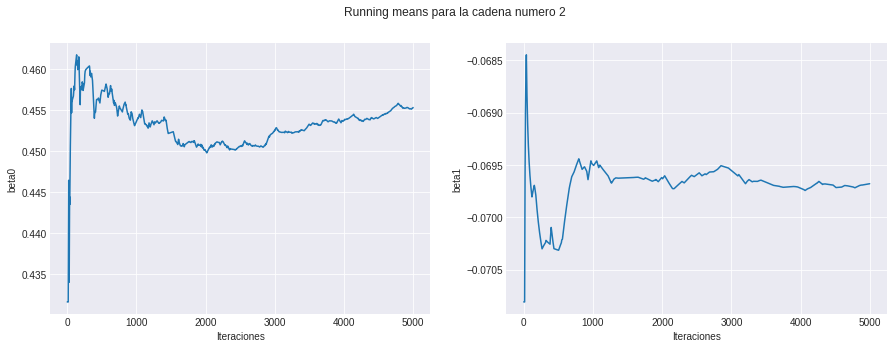

In [34]:
running_means(wake1_met)

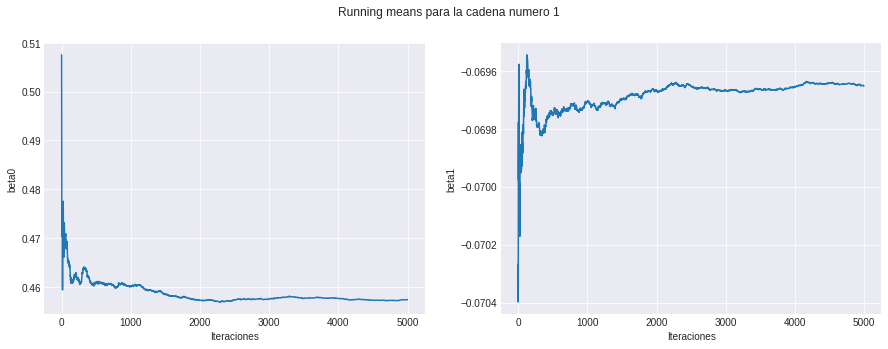

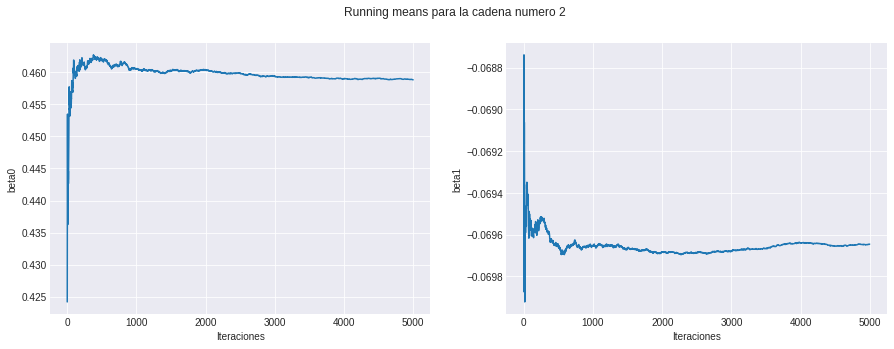

In [35]:
running_means(wake1_ss)

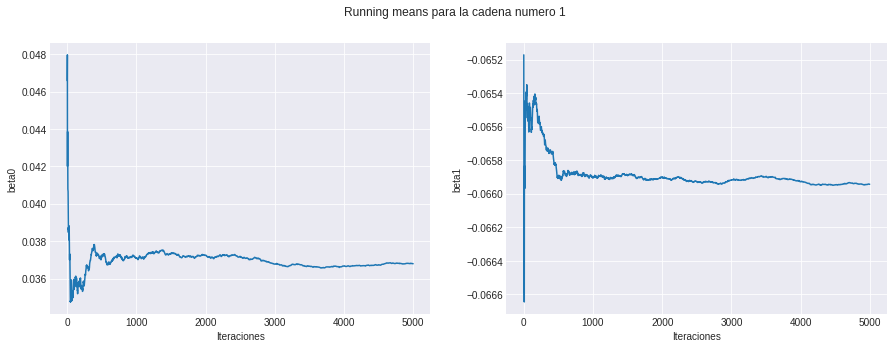

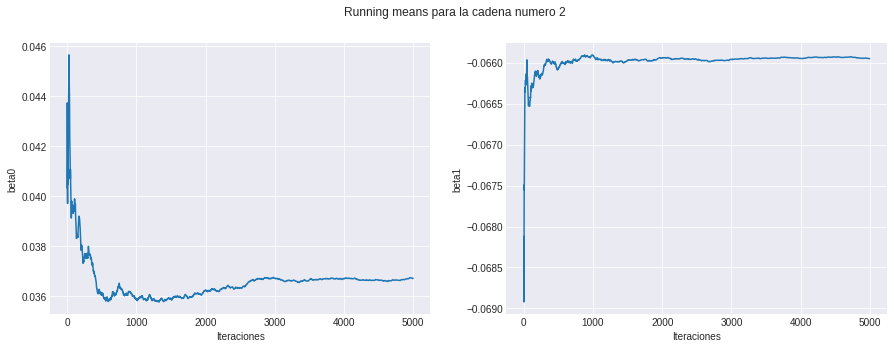

In [36]:
running_means(wake1_hmc)

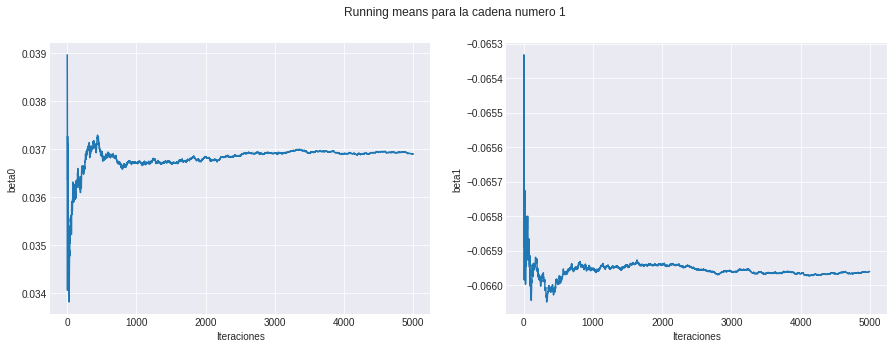

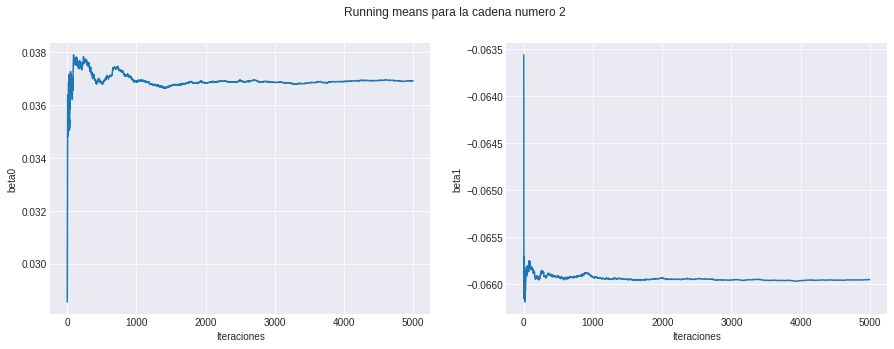

In [37]:
running_means(wake1_nut)

Se puede ver como para todos los algoritmos se logra llegar a un promedio estable dentro de las muestras obtenidas con cada algoritmo, excepto en Metropolis que cuesta ver dicha estabilidad, pero se ve que tiene una clara tendencia. 

NUTS es el algoritmo que logra una convergencia a la media más rápida.

### Resultados

In [43]:
print('La probabilidad de estar dormido supera el 50% a las:')
print('Metropolis\t 6:{} AM.'.format(int(wake1_time_est[np.where(wake1_met_est < 0.5)[0][0]][0])))
print('Slice Sam.\t 6:{} AM.'.format(int(wake1_time_est[np.where(wake1_ss_est < 0.5)[0][0]][0])))
print('HMC       \t 6:{} AM.'.format(int(wake1_time_est[np.where(wake1_hmc_est < 0.5)[0][0]][0])))
print('NUTS      \t 6:{} AM.'.format(int(wake1_time_est[np.where(wake1_nut_est < 0.5)[0][0]][0])))

La probabilidad de estar dormido supera el 50% a las:
Metropolis	 6:7 AM.
Slice Sam.	 6:7 AM.
HMC       	 6:1 AM.
NUTS      	 6:1 AM.


In [40]:
def probability_examples(means, method):
    print("Usando %s Probabilidad de estar dormido a las:" % method)
    print('6:00 PM : {:.2f}%.'.format(100 * reg_logistic(0, means[0], means[1])))
    print('5:30 PM : {:.2f}%.'.format(100 * reg_logistic(-30, means[0], means[1])))
    print('6:30 PM : {:.2f}%.'.format(100 * reg_logistic(30, means[0], means[1])))

probability_examples(wake1_met_means, "Metropolis")
probability_examples(wake1_ss_means, "Slice Sampling")
probability_examples(wake1_hmc_means, "HMC")
probability_examples(wake1_nut_means, "NUTS")

Usando Metropolis Probabilidad de estar dormido a las:
6:00 PM : 61.19%.
5:30 PM : 92.73%.
6:30 PM : 16.31%.
Usando Slice Sampling Probabilidad de estar dormido a las:
6:00 PM : 61.27%.
5:30 PM : 92.75%.
6:30 PM : 16.38%.
Usando HMC Probabilidad de estar dormido a las:
6:00 PM : 50.92%.
5:30 PM : 88.24%.
6:30 PM : 12.55%.
Usando NUTS Probabilidad de estar dormido a las:
6:00 PM : 50.92%.
5:30 PM : 88.24%.
6:30 PM : 12.55%.


In [44]:
def wake_posterior(time_offset, time, beta0_samples, beta1_samples):
    figsize(16, 8)
    prob = reg_logistic(time_offset, beta0_samples, beta1_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Distribución de probabilidad para despertar a las %s AM' % time)
    plt.xlabel('Probabilidad de despetar'); plt.ylabel('Muestras')
    plt.show();

Escogiendo los resultados del mejor algormitmo de muestreo según los análisis previos se muestra la distribución de los resultados, es decir la distribución de probabilidad de despertar a cierta hora específica. En este caso el algoritmo que mejor se comporto fue NUTS.

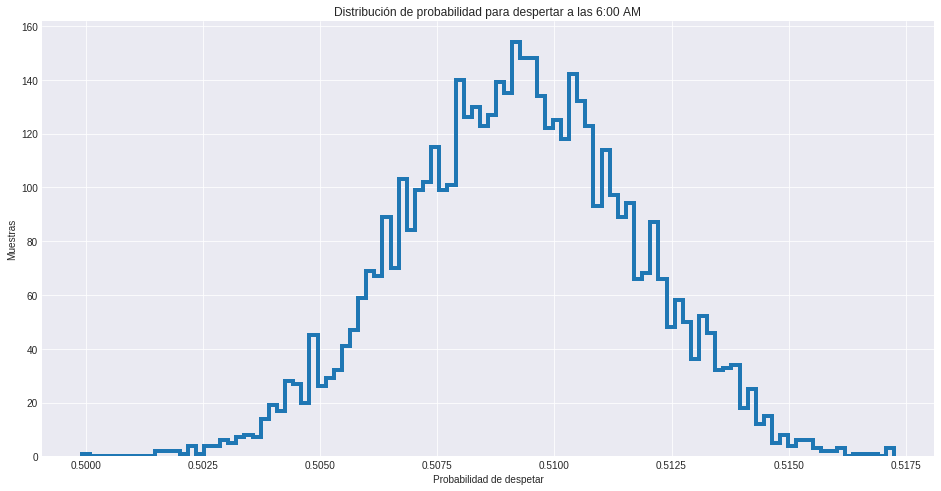

In [45]:
wake_posterior(0, '6:00', wake1_nut_b[0], wake1_nut_b[1])

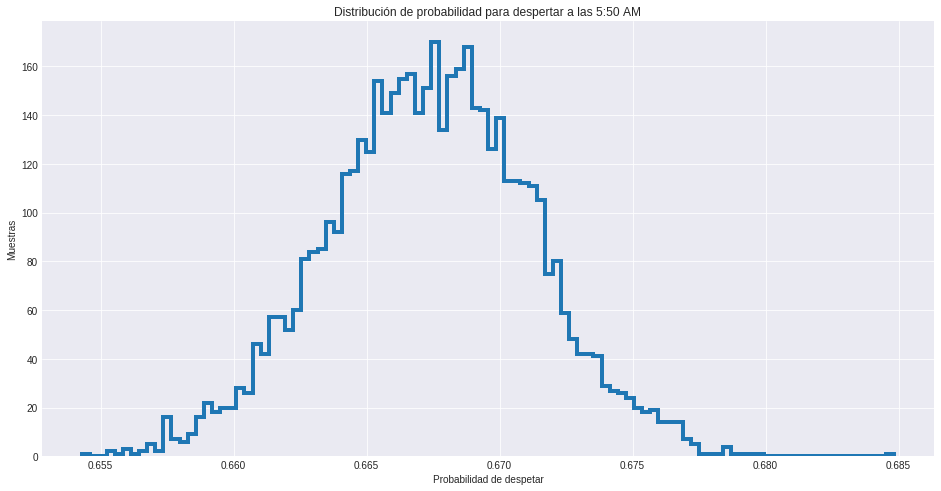

In [46]:
wake_posterior(-10, '5:50', wake1_nut_b[0], wake1_nut_b[1])

## Modelo Despertar +/-2 hora


### Análisis muestreo

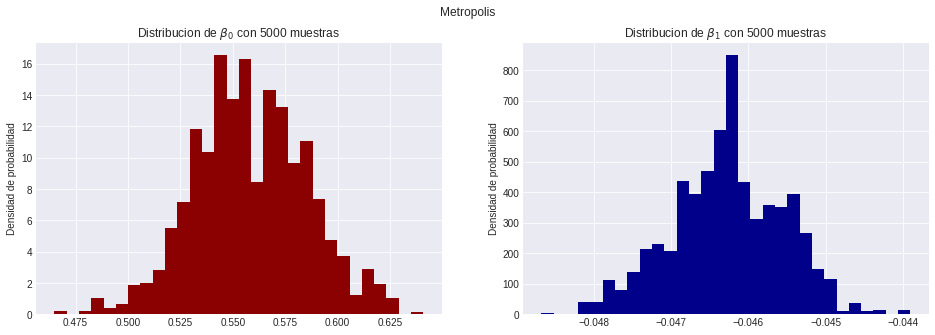

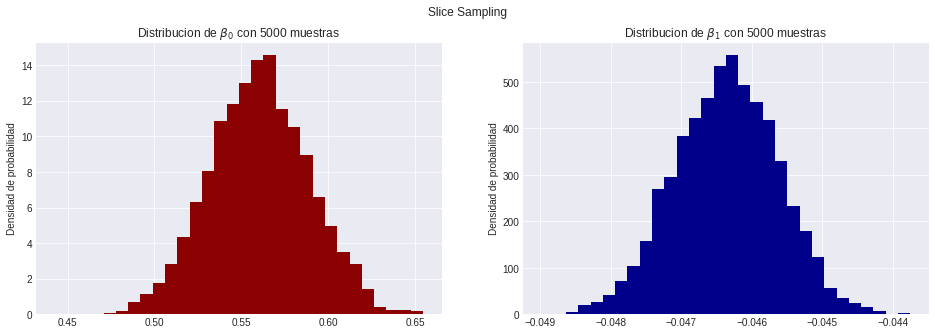

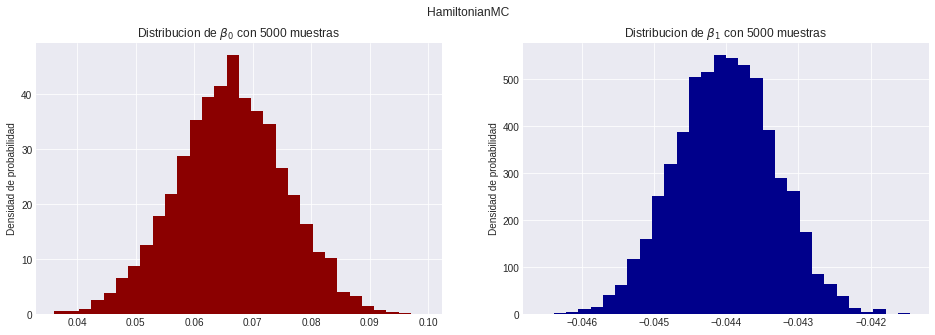

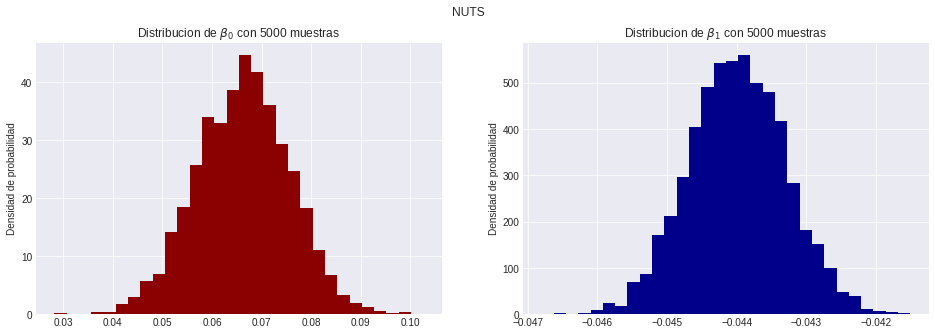

In [50]:
wake2_met_b = [wake2_met["beta0"][5000:], wake2_met["beta1"][5000:]]
wake2_ss_b  = [wake2_ss["beta0"][5000:],  wake2_ss["beta1"][5000:]]
wake2_hmc_b = [wake2_hmc["beta0"][5000:], wake2_hmc["beta1"][5000:]]
wake2_nut_b = [wake2_nut["beta0"][5000:], wake2_nut["beta1"][5000:]]

plot_hist(wake2_met_b[0], wake2_met_b[1], n_samples, "Metropolis")
plot_hist(wake2_ss_b[0],  wake2_ss_b[1], n_samples, "Slice Sampling")
plot_hist(wake2_hmc_b[0], wake2_hmc_b[1], n_samples, "HamiltonianMC")
plot_hist(wake2_nut_b[0], wake2_nut_b[1], n_samples, "NUTS")

In [51]:
wake2_time_est = np.linspace(wake2_time.min()- 15, wake2_time.max() + 15)[:, None]

wake2_met_means = [wake2_met_b[0].mean(), wake2_met_b[1].mean()]
wake2_ss_means  = [wake2_ss_b[0].mean(),  wake2_ss_b[1].mean()]
wake2_hmc_means = [wake2_hmc_b[0].mean(), wake2_hmc_b[1].mean()]
wake2_nut_means = [wake2_nut_b[0].mean(), wake2_nut_b[1].mean()]

# Probabilidad en cada tiempo dado por las medias de las betas
wake2_met_est = reg_logistic(wake2_time_est, wake2_met_means[0], wake2_met_means[1])
wake2_ss_est  = reg_logistic(wake2_time_est, wake2_ss_means[0],  wake2_ss_means[1])
wake2_hmc_est = reg_logistic(wake2_time_est, wake2_hmc_means[0], wake2_hmc_means[1])
wake2_nut_est = reg_logistic(wake2_time_est, wake2_nut_means[0], wake2_nut_means[1])

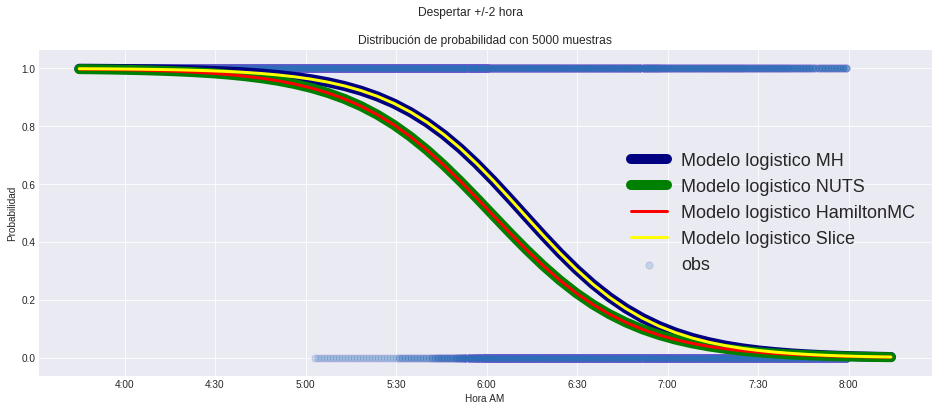

In [52]:
plot_fit(wake2_time_est, wake2_met_est, wake2_nut_est, wake2_hmc_est, wake2_ss_est,
         wake2_time, wake2_obs, n_samples, "Despertar +/-2 hora", "AM", wake_labels)

Nuevamente se ve como el histograma de las muestras tienen un comportamiento normal bien definido, y Metropolis Hasting es el menos definido en tal sentido. Además sigue ocurriendo que Metropolis-Hasting y Slice Sampling tienen un comportamiento muy parecido, asi como HamiltonianMC y NUTS lo tienen. No obstante, estas similitudes no son tan extrañas si se revisa como funciona cada uno de ellos.

Con este modelo que considera un rango de tiempo de +/- 2 horas desde la hora habitual de despertar, se ve como la curva logística se adapta mejor a los datos en sus colas.

### Análisis de convergencia

#### Métodos gráficos

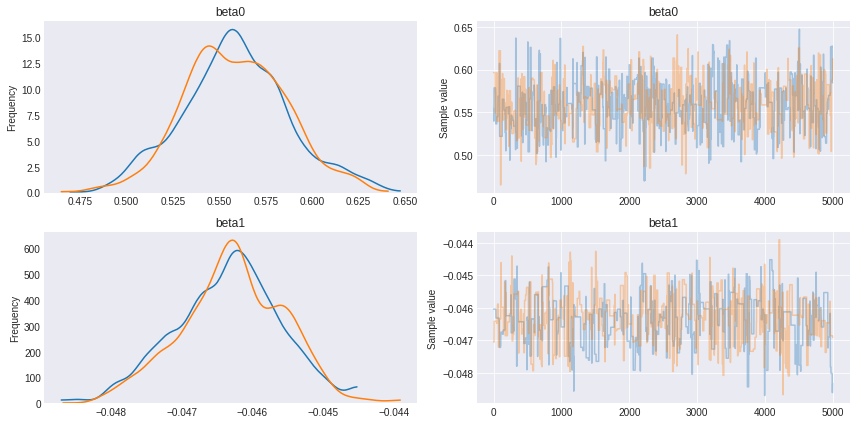

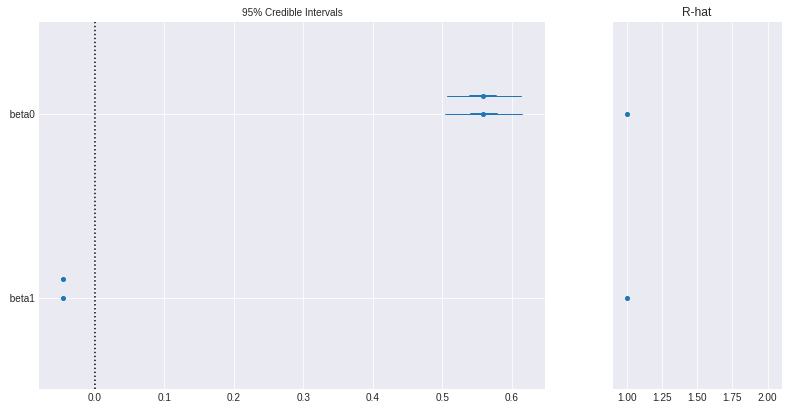

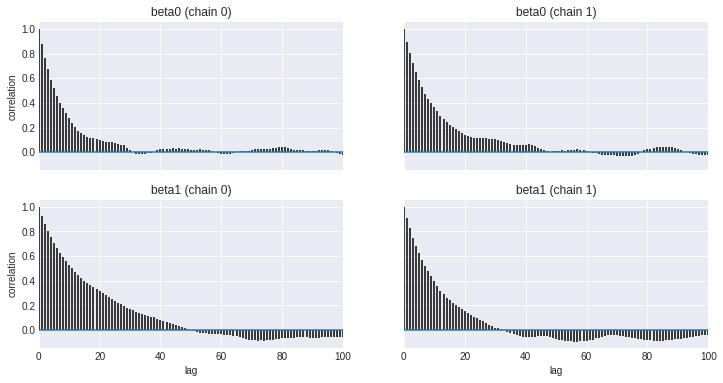

In [53]:
graph_analysis(wake2_met, "Despetar +/-2 hora Metropolis");

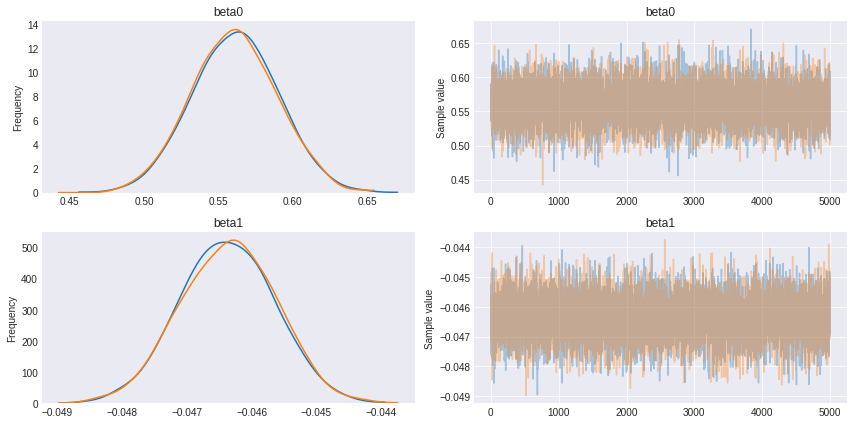

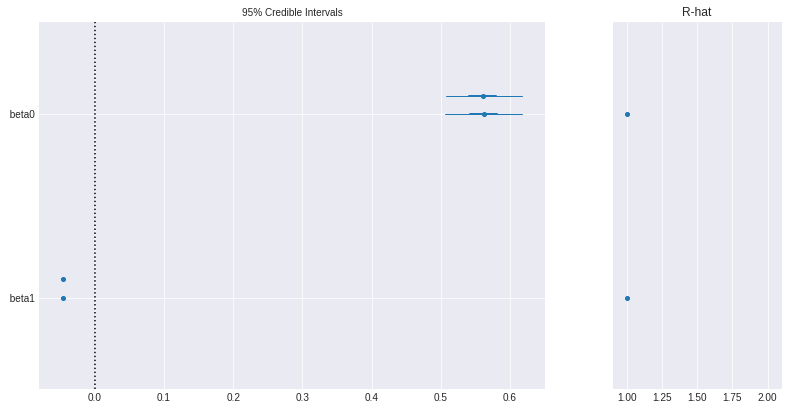

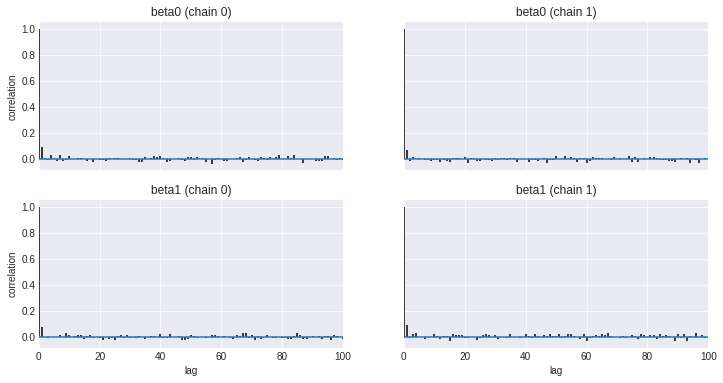

In [54]:
graph_analysis(wake2_ss, "Despetar +/-2 hora Slice Sampling");

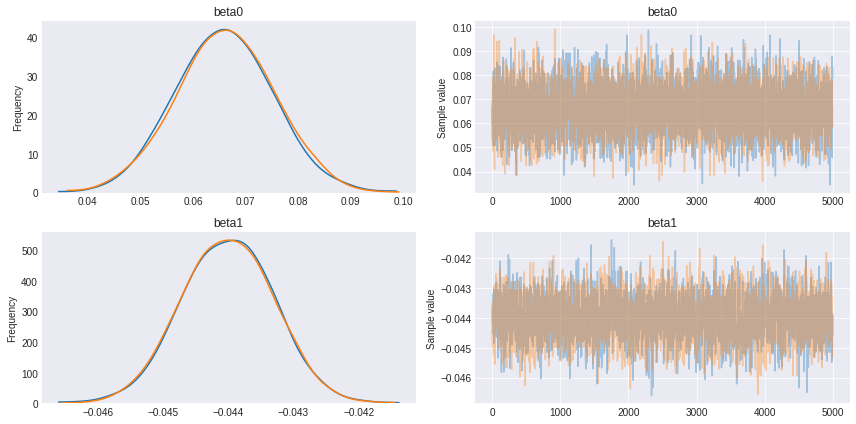

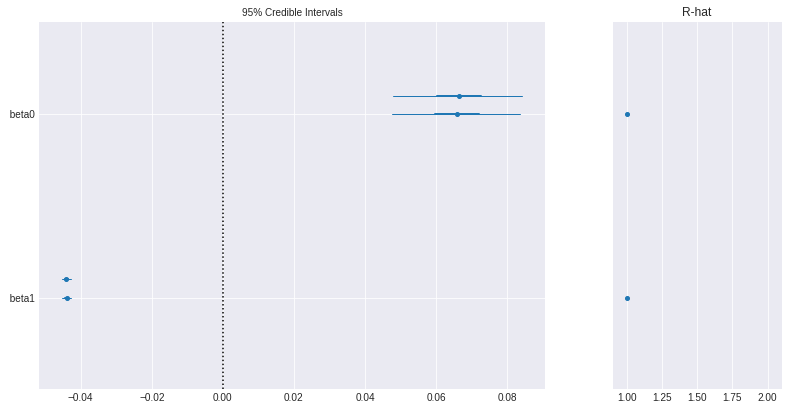

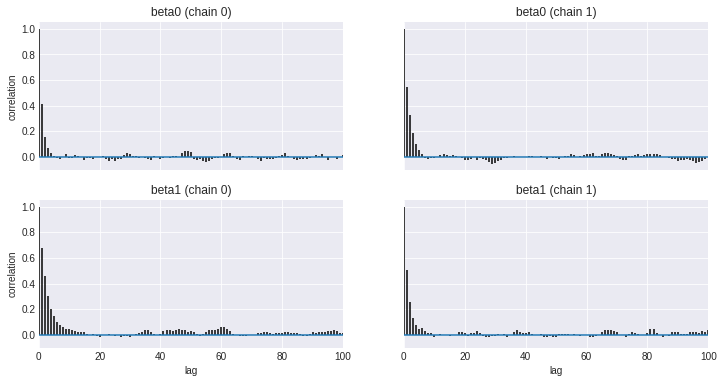

In [55]:
graph_analysis(wake2_hmc, "Despetar +/-2 hora HamiltonianMC");

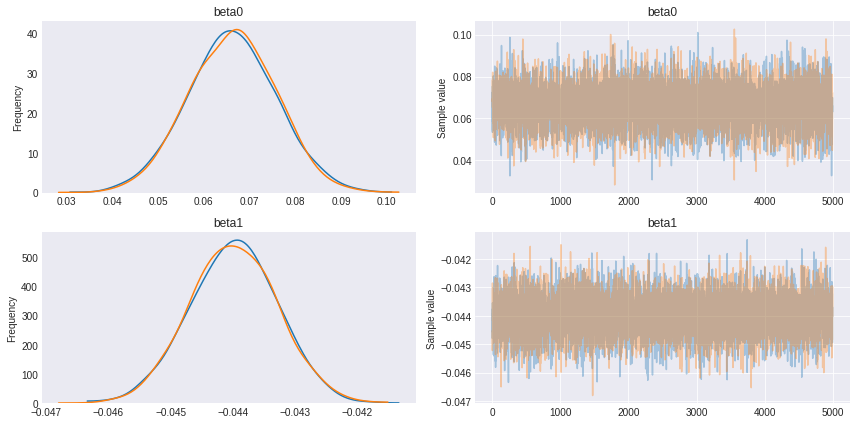

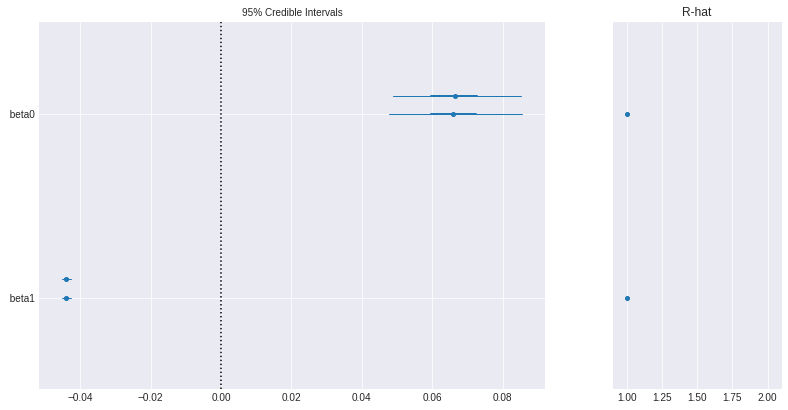

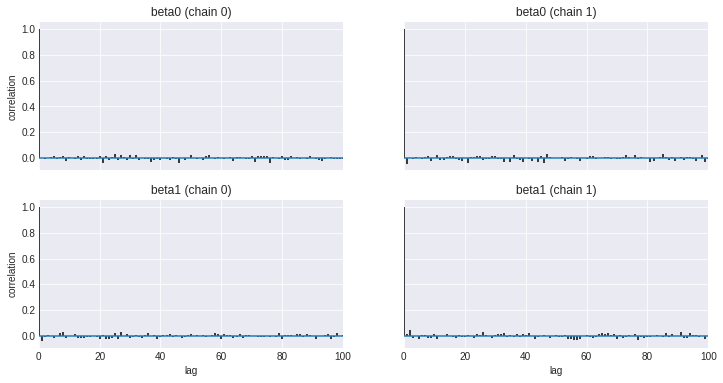

In [56]:
graph_analysis(wake2_nut, "Despetar +/-2 hora NUTS");

Mediante el traceplot se apoya lo encontrado por los primeros histogramas, y se muestra como ambas cadenas obtenidas tienen la misma distribución.

EL forestplot muestra que en todos lo algoritmos se logra una convergencia según la prueba de convergencia de R-hat de Gelman-Rubin, y esa convergencia con su intervalo de confianza se ve en la gráfica del lado derecho, donde su intervalo de confianza del parámetro $\beta_1$ es menor.

Por la autocorrelación se ve que NUTS tiene un mejor comportamiento, pues logra una independencia de muestro más rápido.

#### Geweke

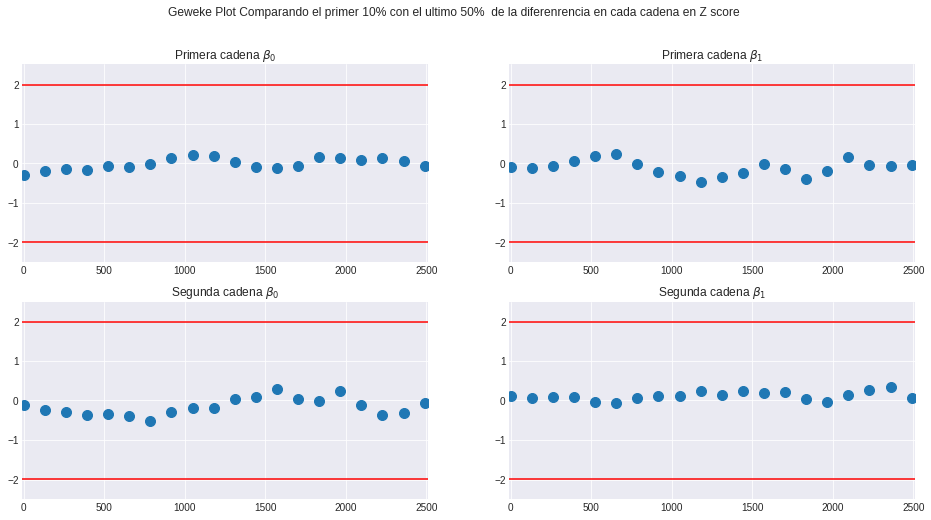

In [57]:
geweke(wake2_met)

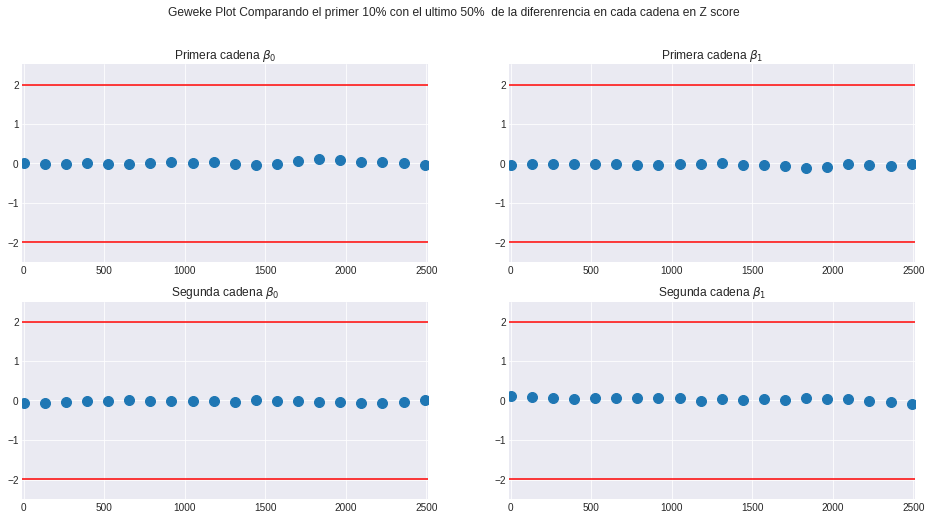

In [58]:
geweke(wake2_ss)

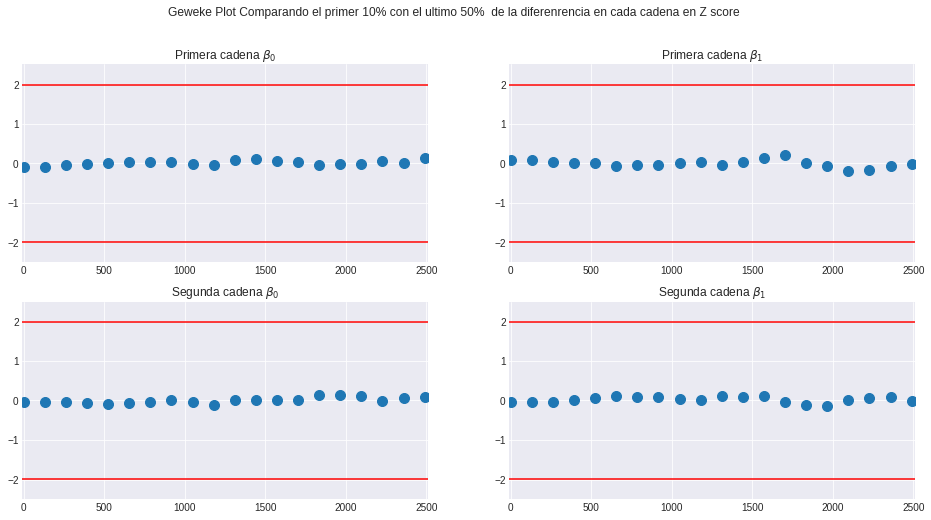

In [59]:
geweke(wake2_hmc)

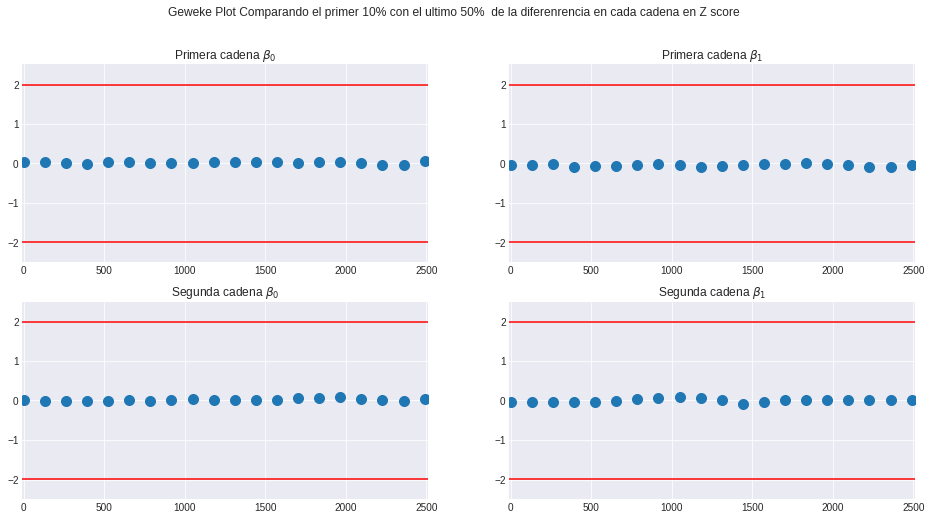

In [60]:
geweke(wake2_nut)

Con el método de convergencia Geweke se corrobora lo mencionado anteriormente, o sea que las muestras obtenidas son aceptables, pued convergen. Nuevamente se ve que Metropolis Hasting es el que tiene mayor curvatura, por lo que es el que "peor" se comporta. Por otro lado NUTS y Slice Sampling son los que mejor se comportan  de acuerdi a este método.

#### Gelman-Rubin

In [61]:
gelman_rubin(wake2_met)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.999947332100971
	 El parámetro beta1 ha convergido
	 	 beta1:  1.003086539978013


In [62]:
gelman_rubin(wake2_ss)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  1.0002221886738043
	 El parámetro beta1 ha convergido
	 	 beta1:  1.0001808741289446


In [63]:
gelman_rubin(wake2_hmc)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  1.0001895855892817
	 El parámetro beta1 ha convergido
	 	 beta1:  0.9999126235581146


In [64]:
gelman_rubin(wake2_nut)

Convergencia de Gelman-Rubin
	 El parámetro beta0 ha convergido
	 	 beta0:  0.999961334847286
	 El parámetro beta1 ha convergido
	 	 beta1:  0.9999198698582347


Una vez más esta sección que muestra de forma más explícita el resutado de convergencia de Gelman-Rubin, corroboran lo anteriormente expuesto, en donde todas los algoritmos de muestreo convergen. Es díficil mencionar qué algoritmo es mejor, pues todos los valores del estadístico R de Gelman-Rubin son muy similares y estan el un rango muy aceptable por lo cercano a 1.

#### Running Means

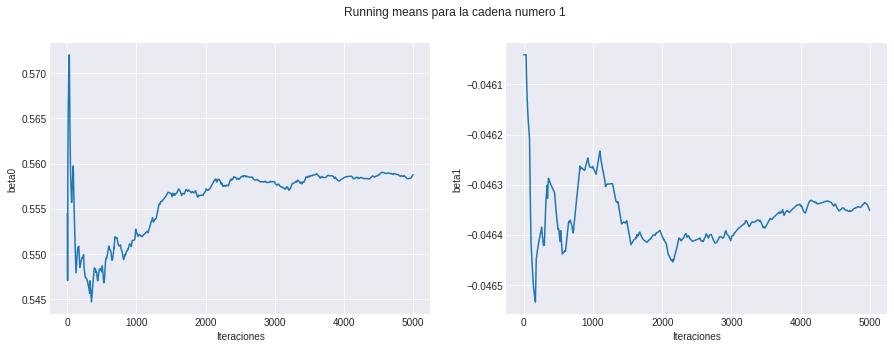

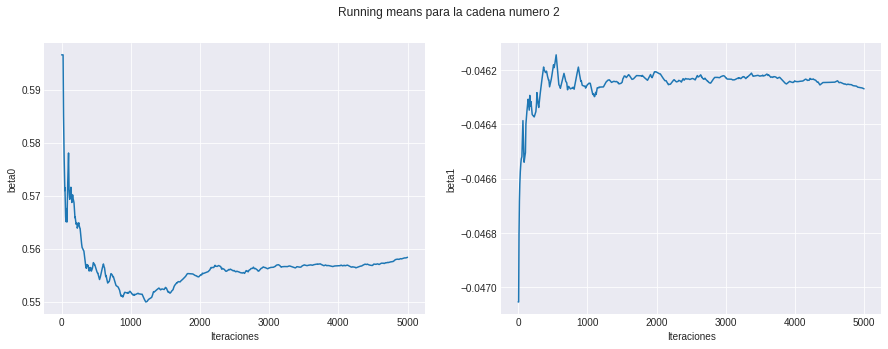

In [65]:
running_means(wake2_met)

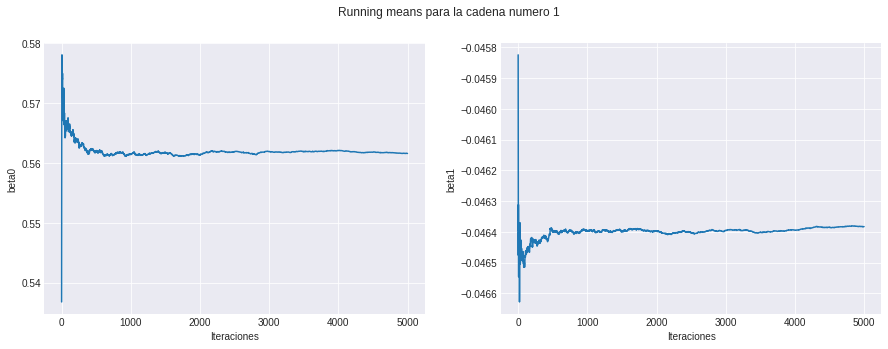

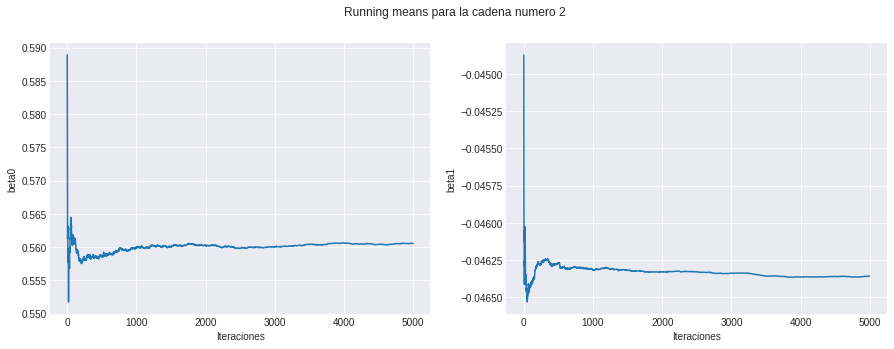

In [66]:
running_means(wake2_ss)

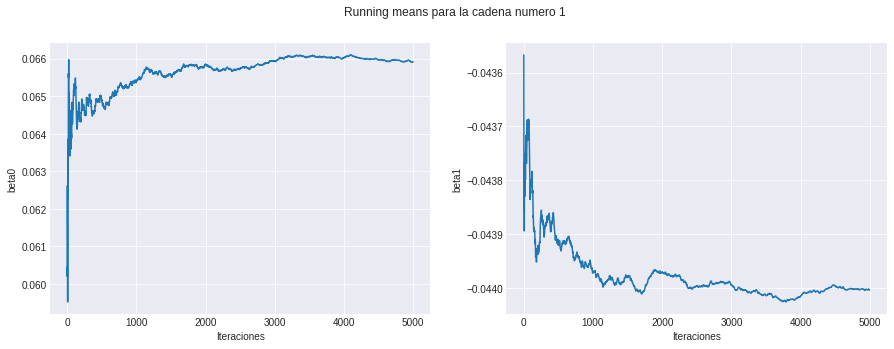

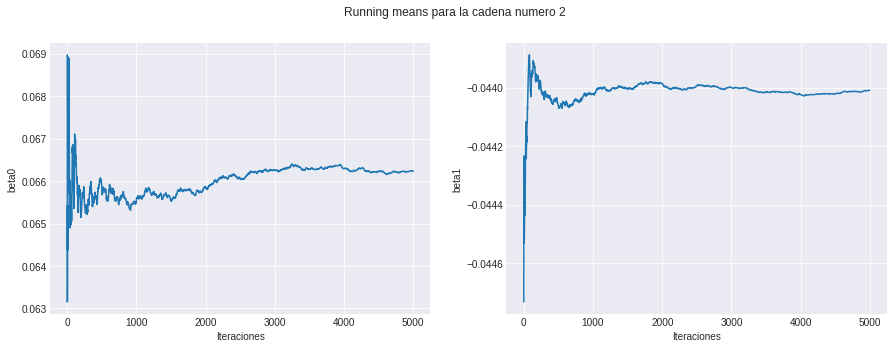

In [67]:
running_means(wake2_hmc)

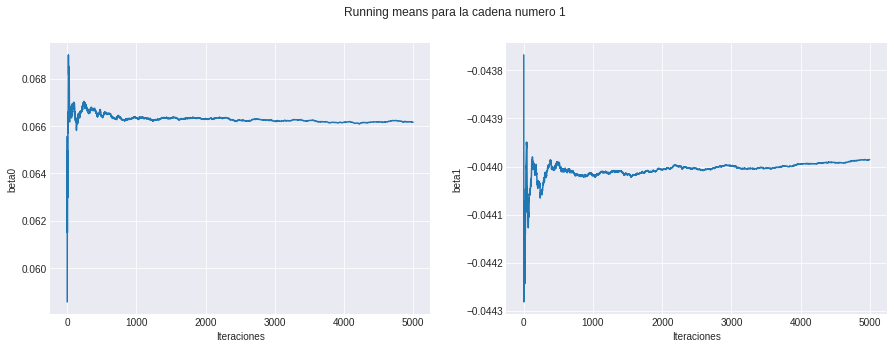

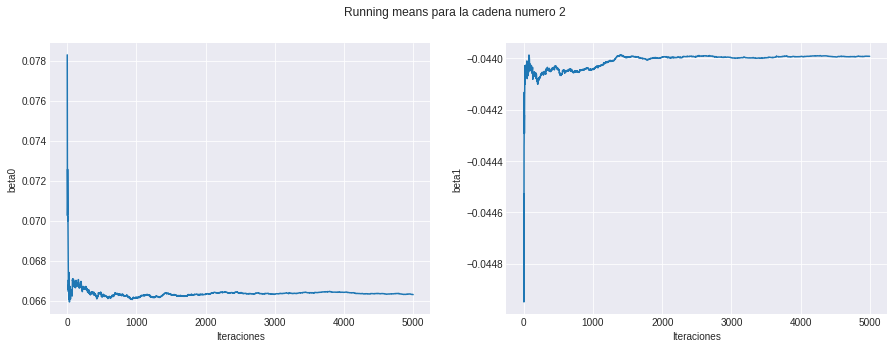

In [68]:
running_means(wake2_nut)

De acuerdo al método de convergencia los métodos que mejor se comportan son NUTS y Slice Sampling como se encontró con Geweke.

### Resultados

In [69]:
print('La probabilidad de estar dormido supera el 50% a las:')
print('Metropolis\t 6:{} AM.'.format(int(wake2_time_est[np.where(wake2_met_est < 0.5)[0][0]][0])))
print('Slice Sam.\t 6:{} AM.'.format(int(wake2_time_est[np.where(wake2_ss_est < 0.5)[0][0]][0])))
print('HMC       \t 6:{} AM.'.format(int(wake2_time_est[np.where(wake2_hmc_est < 0.5)[0][0]][0])))
print('NUTS      \t 6:{} AM.'.format(int(wake2_time_est[np.where(wake2_nut_est < 0.5)[0][0]][0])))

La probabilidad de estar dormido supera el 50% a las:
Metropolis	 6:13 AM.
Slice Sam.	 6:13 AM.
HMC       	 6:2 AM.
NUTS      	 6:2 AM.


In [70]:
def probability_examples(means, method):
    print("Usando %s Probabilidad de estar dormido a las:" % method)
    print('6:00 PM : {:.2f}%.'.format(100 * reg_logistic(0, means[0], means[1])))
    print('5:30 PM : {:.2f}%.'.format(100 * reg_logistic(-30, means[0], means[1])))
    print('6:30 PM : {:.2f}%.'.format(100 * reg_logistic(30, means[0], means[1])))

probability_examples(wake2_met_means, "Metropolis")
probability_examples(wake2_ss_means, "Slice Sampling")
probability_examples(wake2_hmc_means, "HMC")
probability_examples(wake2_nut_means, "NUTS")

Usando Metropolis Probabilidad de estar dormido a las:
6:00 PM : 63.61%.
5:30 PM : 87.51%.
6:30 PM : 30.37%.
Usando Slice Sampling Probabilidad de estar dormido a las:
6:00 PM : 63.66%.
5:30 PM : 87.56%.
6:30 PM : 30.36%.
Usando HMC Probabilidad de estar dormido a las:
6:00 PM : 51.66%.
5:30 PM : 80.00%.
6:30 PM : 22.20%.
Usando NUTS Probabilidad de estar dormido a las:
6:00 PM : 51.66%.
5:30 PM : 80.00%.
6:30 PM : 22.21%.


Escogiendo las muestras del mejor algoritmo según las pruebas de convergencia.

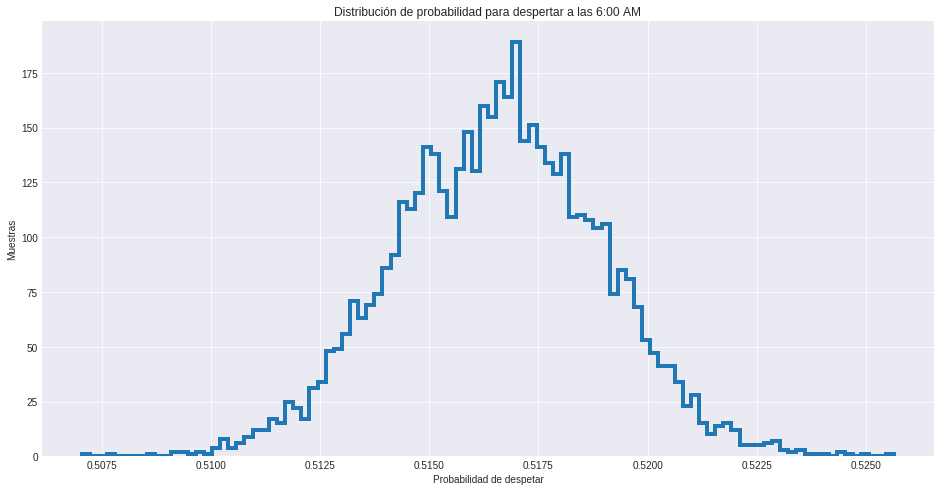

In [71]:
wake_posterior(0, '6:00', wake2_nut_b[0], wake2_nut_b[1])

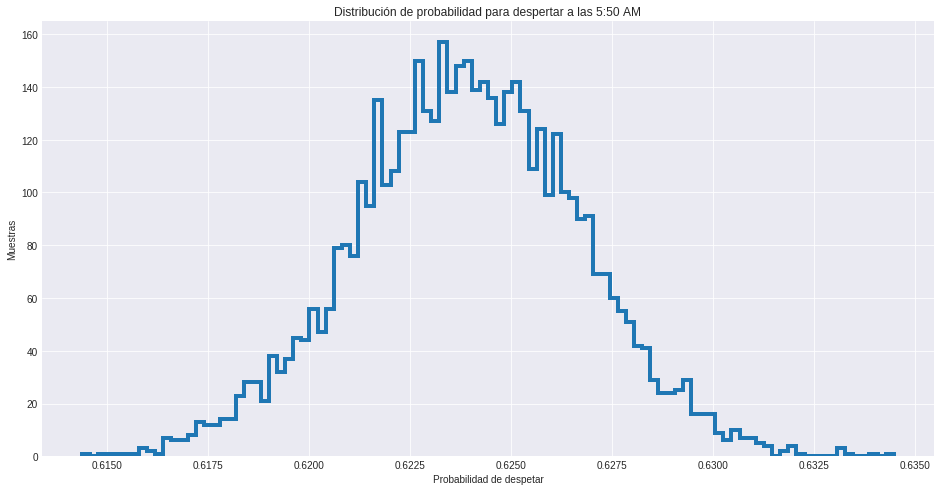

In [72]:
wake_posterior(-10, '5:50', wake2_nut_b[0], wake2_nut_b[1])

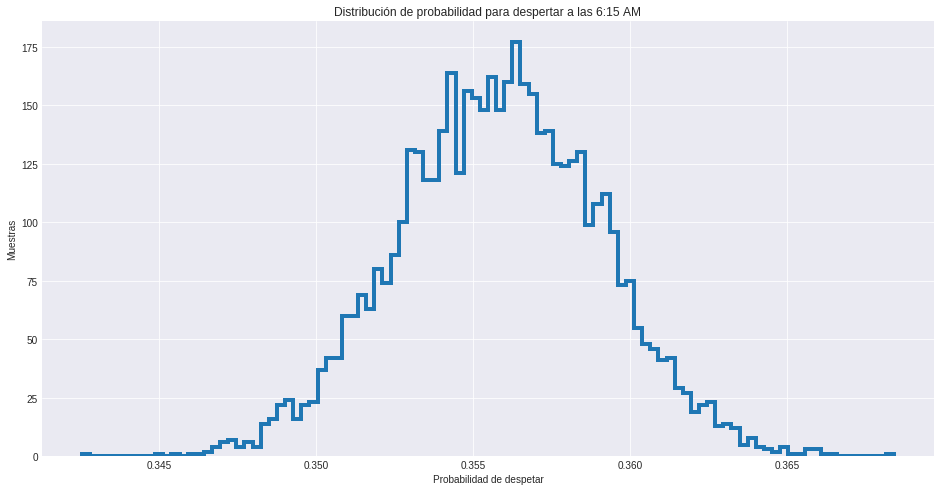

In [73]:
wake_posterior(15, '6:15', wake2_nut_b[0], wake2_nut_b[1])